In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Image_Segmentation_Full_Body_MADS_UNet")
!ls

Mounted at /content/drive
Dataset  Image_Segmentation_Full_Body_MADS_UNet.ipynb


In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
X_ids = next(os.walk('Dataset/images'))[2]
y_ids = next(os.walk('Dataset/masks'))[2]

In [3]:
IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT = 3, 512, 512

In [4]:
X_train = np.zeros((len(X_ids), 256, 256, 3), dtype=np.float32)
y_train = np.zeros((len(y_ids), 256, 256, 1), dtype=np.bool)

for n, id_ in enumerate(X_ids):
    image = tf.keras.preprocessing.image.load_img(f'Dataset/images/{id_}', target_size=(IMG_HEIGHT, IMG_WIDTH))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)[90:450,150:406]
    image = tf.keras.preprocessing.image.array_to_img(input_arr, ).resize((256, 256))
    X_train[n] = np.array(image)

for n, id_ in enumerate(y_ids):
    image = tf.keras.preprocessing.image.load_img(f'Dataset/masks/{id_}', 
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)[90:450,150:406]
    image = tf.keras.preprocessing.image.array_to_img(input_arr).resize((256, 256))
    y_train[n] = np.array(image)[:, :, np.newaxis]

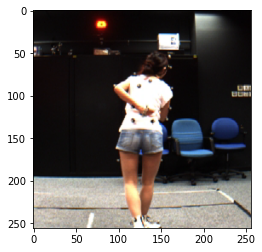

In [5]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(X_train[1000]))

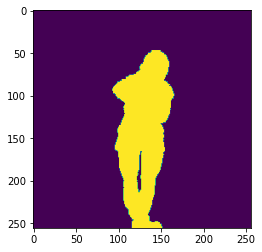

In [6]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(y_train[1000]))

In [7]:
inputs = tf.keras.layers.Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Metal device set to: Apple M1


2021-07-31 10:31:18.491836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-07-31 10:31:18.492295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [8]:
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=25)

2021-07-31 10:31:20.990712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-31 10:31:20.994066: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/25


2021-07-31 10:31:21.353021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 0.3590 - accuracy: 0.8624

2021-07-31 10:31:57.355172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 38s 535ms/step - loss: 0.3590 - accuracy: 0.8624 - val_loss: 0.2328 - val_accuracy: 0.9025
Epoch 2/25
67/67 [==============================] - 35s 523ms/step - loss: 0.2061 - accuracy: 0.9153 - val_loss: 0.1718 - val_accuracy: 0.9343
Epoch 3/25
67/67 [==============================] - 35s 526ms/step - loss: 0.1055 - accuracy: 0.9577 - val_loss: 0.0899 - val_accuracy: 0.9673
Epoch 4/25
67/67 [==============================] - 36s 535ms/step - loss: 0.0638 - accuracy: 0.9754 - val_loss: 0.0615 - val_accuracy: 0.9779
Epoch 5/25
67/67 [==============================] - 36s 539ms/step - loss: 0.0452 - accuracy: 0.9825 - val_loss: 0.0512 - val_accuracy: 0.9817
Epoch 6/25
67/67 [==============================] - 35s 526ms/step - loss: 0.0376 - accuracy: 0.9852 - val_loss: 0.0410 - val_accuracy: 0.9854
Epoch 7/25
67/67 [==============================] - 36s 531ms/step - loss: 0.0342 - accuracy: 0.9865 - val_loss: 0.0368 - val_accuracy: 0.9868
Epoch 8/25

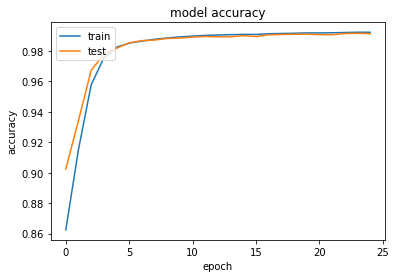

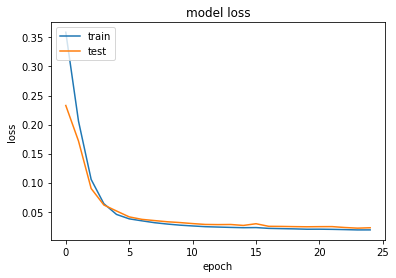

In [9]:
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
import random

test_id = random.choice(X_ids)
print(test_id)

Jazz_Jazz1_C1_00405.png


In [11]:
img = tf.keras.preprocessing.image.load_img(f"Dataset/images/{test_id}", target_size=(256, 256))
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = np.array([input_array])  # Convert single image to a batch.
predictions = model.predict(input_array)

2021-07-31 10:46:07.239562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


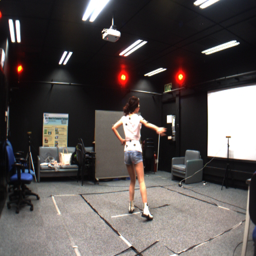

In [12]:
Image.open(f"Dataset/images/{test_id}").resize((256, 256))

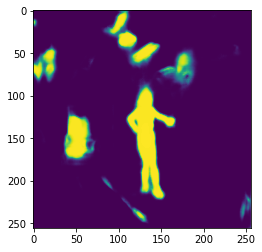

In [13]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(np.squeeze(predictions)[:, :, np.newaxis]))

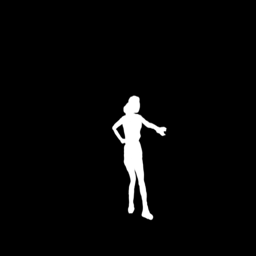

In [14]:
Image.open(f"Dataset/masks/{test_id}").resize((256 ,256))